## Imports

In [1]:
from google.colab import drive
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm
figure(figsize=(10, 10))

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In this assignment, we are calculating the disparity between two images, taken by two cameras where the transformation between them is a horizontal translation along the x-axis, as shown in the fig. 



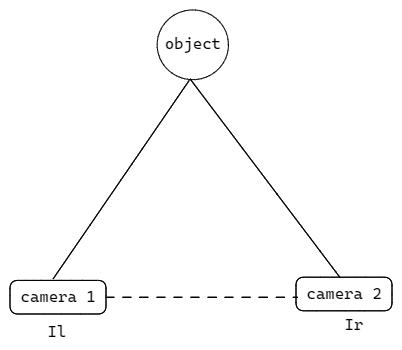

## Mounting Google Drive

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


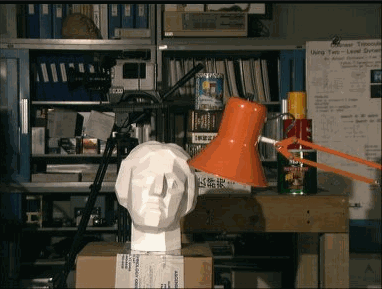

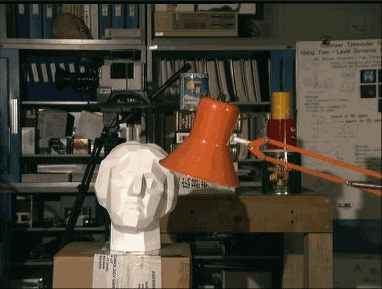

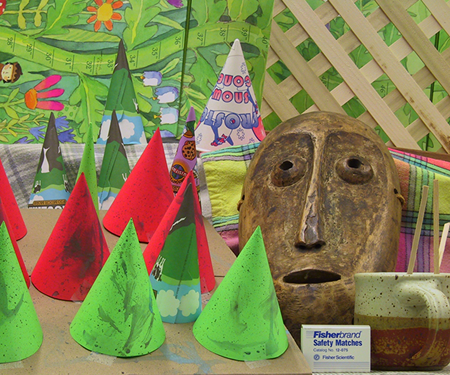

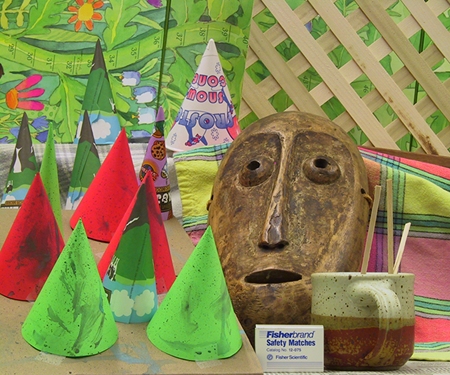

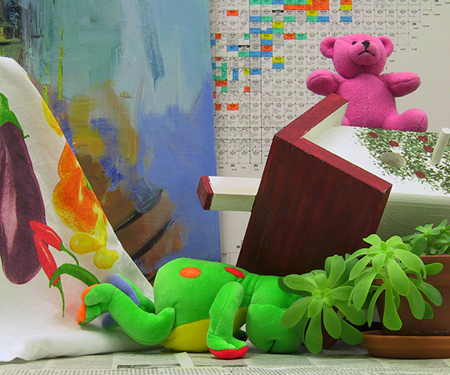

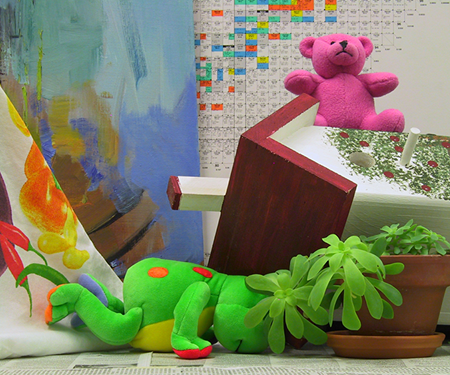

In [3]:
left_img1 = cv2.imread("/content/gdrive/MyDrive/Assignment-3/images/l1.png")
right_img1 = cv2.imread("/content/gdrive/MyDrive/Assignment-3/images/r1.png")

left_img2 = cv2.imread("/content/gdrive/MyDrive/Assignment-3/images/l2.png")
right_img2 = cv2.imread("/content/gdrive/MyDrive/Assignment-3/images/r2.png")

left_img3 = cv2.imread("/content/gdrive/MyDrive/Assignment-3/images/l3.png")
right_img3 = cv2.imread("/content/gdrive/MyDrive/Assignment-3/images/r3.png")

cv2_imshow(left_img1)
cv2_imshow(right_img1)

cv2_imshow(left_img2)
cv2_imshow(right_img2)

cv2_imshow(left_img3)
cv2_imshow(right_img3)

In [4]:
def plot_imgs(left, right, scheme="color"):
  fig, ax = plt.subplots(1,2)
  if scheme == "color":
    scheme = cv2.COLOR_BGR2RGB
  elif scheme == "gray":
    scheme = cv2.COLOR_RGB2GRAY

  ax[0].imshow(cv2.cvtColor(left, scheme))
  ax[1].imshow(cv2.cvtColor(right, scheme))

In [5]:
images = [
    [left_img1, right_img1],
    [left_img2, right_img2],
    [left_img3, right_img3]
    ]

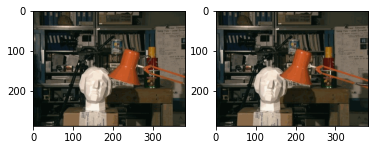

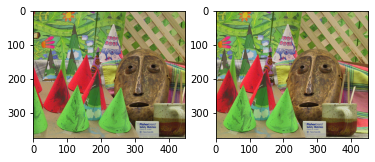

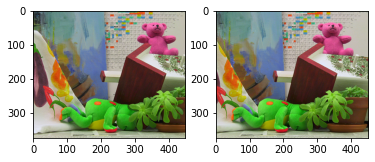

In [6]:
for image_pair in images: 
  plot_imgs(image_pair[0], image_pair[1])

# Block Matching

In [ ]:
def block_matching(rightimg, leftimg, window, measure, show=True):
  rgray = cv2.cvtColor(rightimg, cv2.COLOR_RGB2GRAY)
  lgray = cv2.cvtColor(leftimg, cv2.COLOR_RGB2GRAY)
  height, width = lgray.shape[:2]
  disparity_map = np.empty([height, width], dtype = int)
  half_wind = window//2
  min_index = 0
  # pixel in left image
  for y in range(half_wind,height-half_wind):
    for x in range(half_wind,width-half_wind):
      disp_min = float("inf")
      first_window = lgray[y-half_wind: y+half_wind+1, x-half_wind: x+ half_wind+1]
      sum_1 = np.sum(first_window)
      for l in range(half_wind,x-half_wind):
        second_window = rgray[y-half_wind: y+half_wind+1, l-half_wind:l+half_wind+1]
        if measure == "SAD":
          curr_disp = np.sum(np.abs(np.subtract(first_window,second_window)))
        elif measure == "SSD":
          curr_disp = np.sum(np.square(np.subtract(first_window,second_window)))

        # curr_disp = np.abs(sum_1 - np.sum(second_window))
        if curr_disp < disp_min:
          disp_min = curr_disp
          min_index = l 
        

      disparity_map[y,x] =np.abs(x - min_index)
      # diff = abs(lgray[y,x]-rgray[y,:])
      # min_index = np.argmin(diff)

      # if min_index > x:
      #   disparity_map[y,x] = 0
      # else:
      #   # min_value = min(diff)
      #   disparity_map[y,x] = abs(x-min_index)

  # plt.imshow(disparity_map,cmap='gray')
  if show:
    cv2_imshow(disparity_map)
  return disparity_map

Image #1
# of windows = 1, measure = SAD


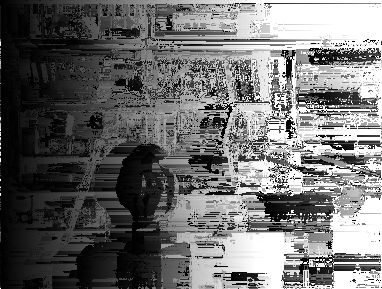

# of windows = 1, measure = SSD


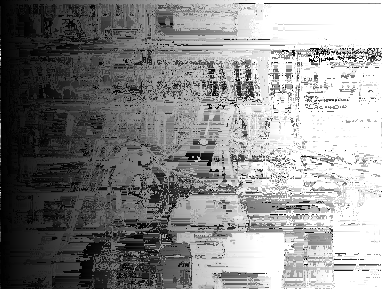

# of windows = 5, measure = SAD


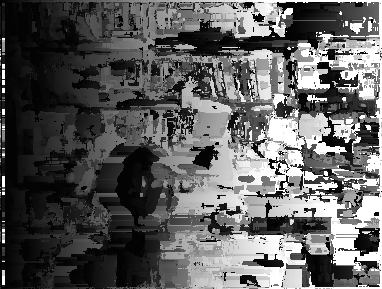

# of windows = 5, measure = SSD


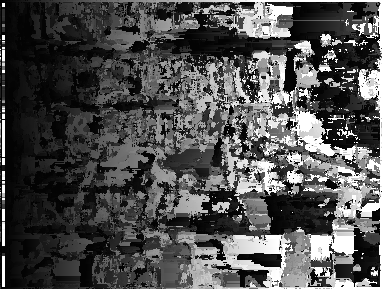

# of windows = 9, measure = SAD


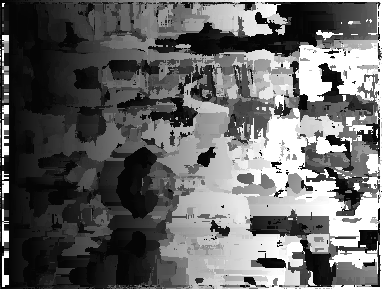

# of windows = 9, measure = SSD


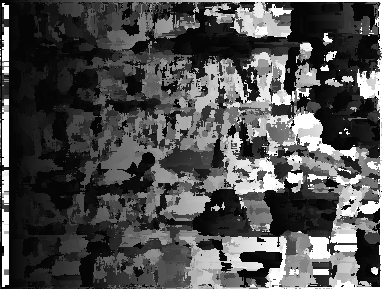

---------------------------
Image #2
# of windows = 1, measure = SAD


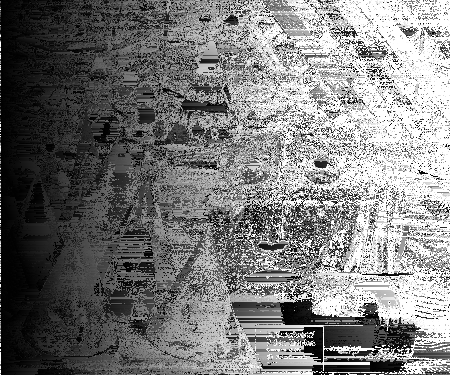

# of windows = 1, measure = SSD


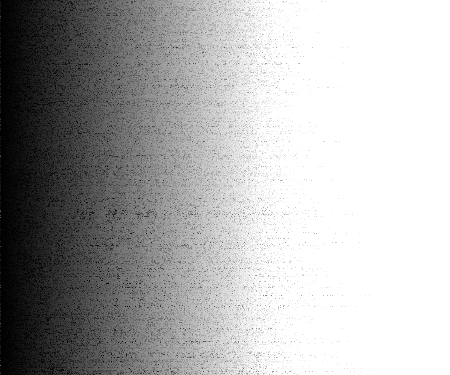

# of windows = 5, measure = SAD


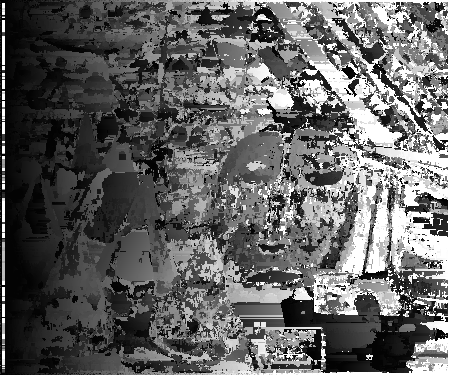

# of windows = 5, measure = SSD


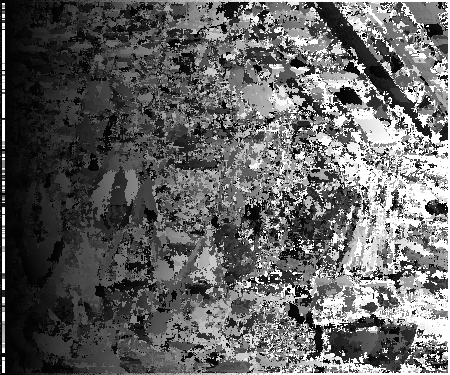

# of windows = 9, measure = SAD


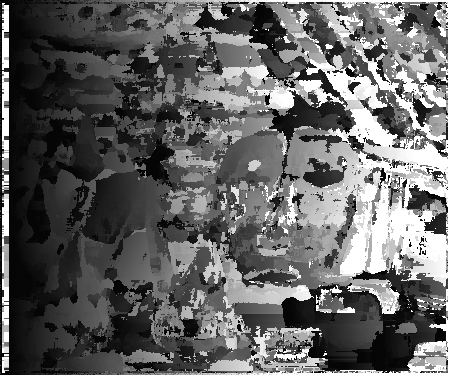

# of windows = 9, measure = SSD


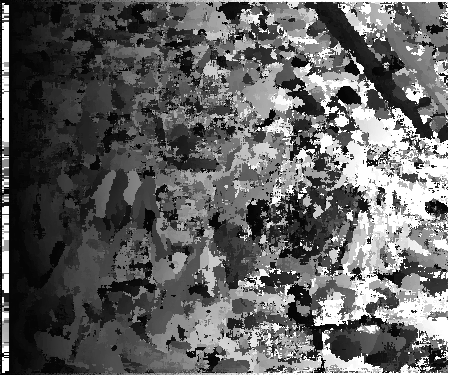

---------------------------
Image #3
# of windows = 1, measure = SAD


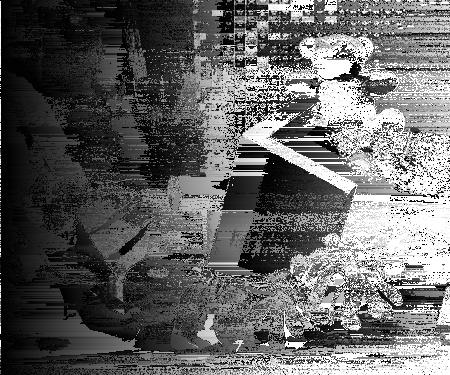

# of windows = 1, measure = SSD


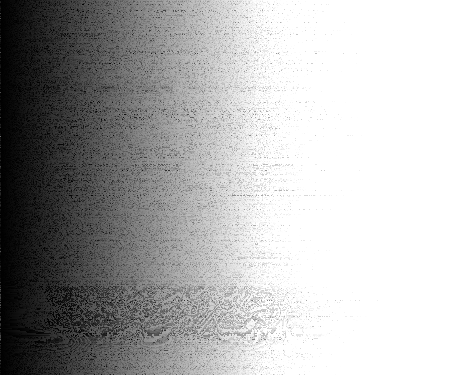

# of windows = 5, measure = SAD


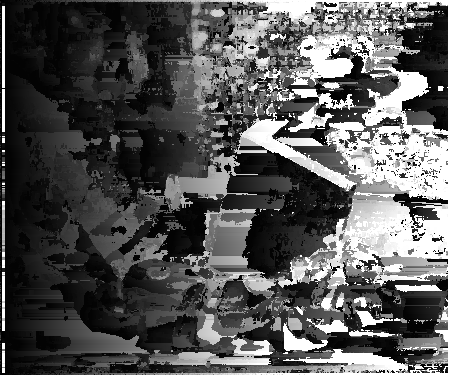

# of windows = 5, measure = SSD


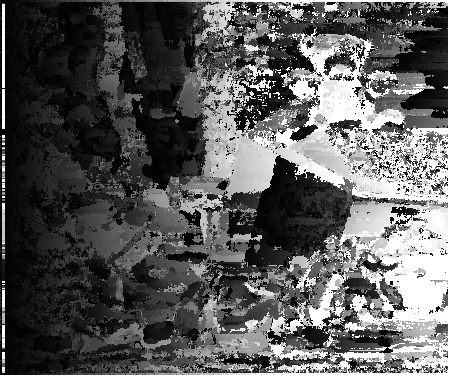

# of windows = 9, measure = SAD


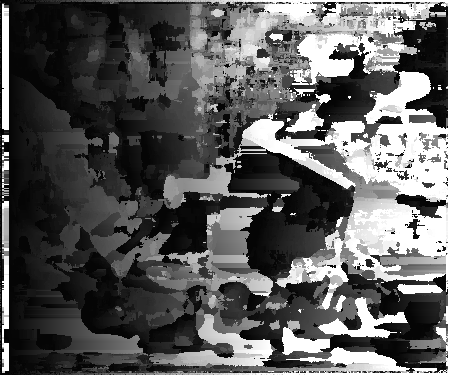

# of windows = 9, measure = SSD


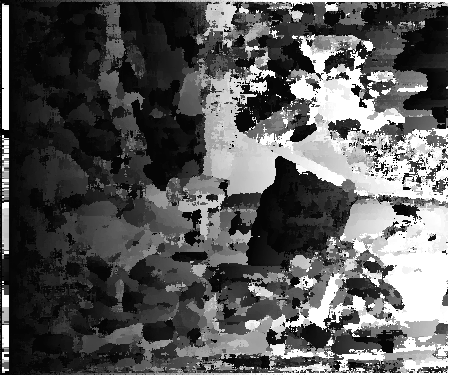

---------------------------


In [ ]:
windows = [1, 5, 9]
measures = ["SAD", "SSD"]
for num, image_pair in enumerate(images):
  print("Image #" + str(num + 1))
  for window in windows:
    for measure in measures:
      print(f"# of windows = {window}, measure = {measure}")
      block_matching(image_pair[0], image_pair[1], window, measure)
  print("---------------------------")

# Dynamic Programming

We will construct an NxN matrix for each scanline (row) where N=number of columns. The i dimension represents the pixels in the left image for this particular row, and the j dimension represents the pixels in the right image. We will work our way down from D(1,1). This matrix contains the cost associated with matching a particular pixel i in the left image to a pixel j in the right image. The cost is calculated using this equation: $D_{ij} = min(D(i − 1, j − 1) + dij , D(i − 1, j) + c0, D(i, j − 1) + c0)$ 

where $d_{ij} = \frac{(I_l(i) - I_r(j))^2}{\sigma^2}$ 

and the initial $D(1,1) = d_{11}$



Along with the NxN matrix m that contains the optimal costs for matching each pixel, we can also construct another NxN matrix b that contains one of 3 values, 0, 1, 2. Where:

0 : denotes that the minimum cost was in the direction of moving (i-1, j-1) and indicates a match

1 : denotes that the minimum cost was in the direction of moving (i-1, j) and indicates that a pixel was skipped (occluded) in the right image

2 : denotes that minimum cost was in the direction of moving (i, j-1) and indicates that a pixel was skipped in the left image

So from b we can construct 2 disparity maps, one from the right image's perspective and one from the left's.

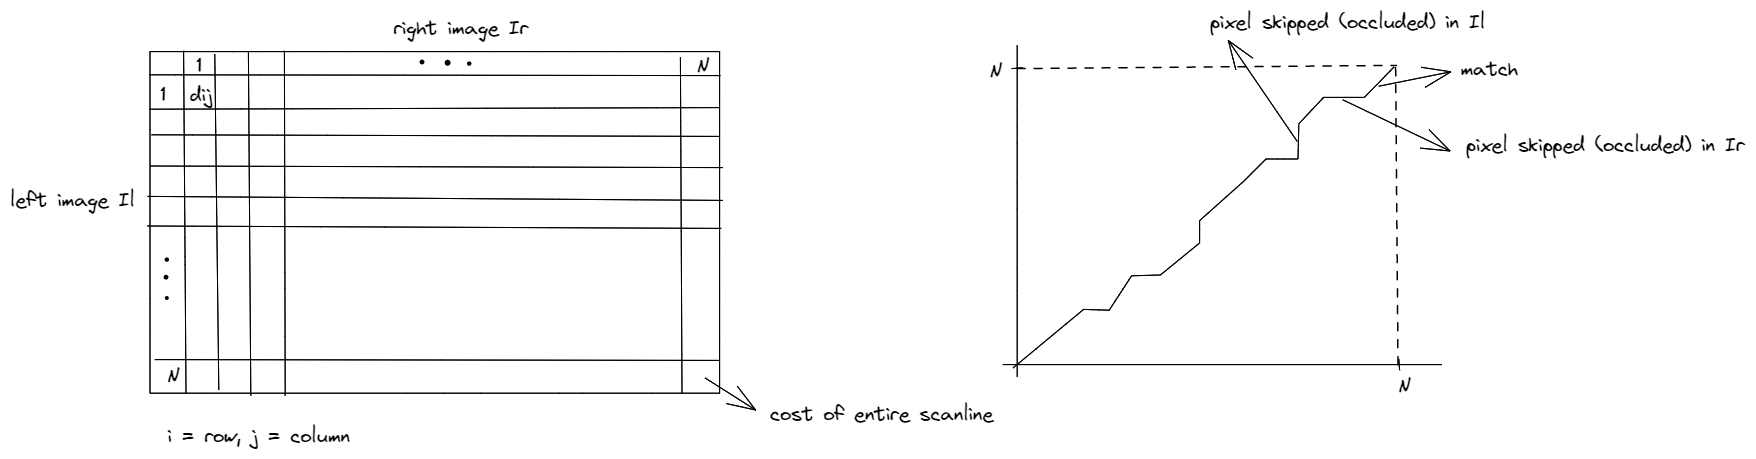

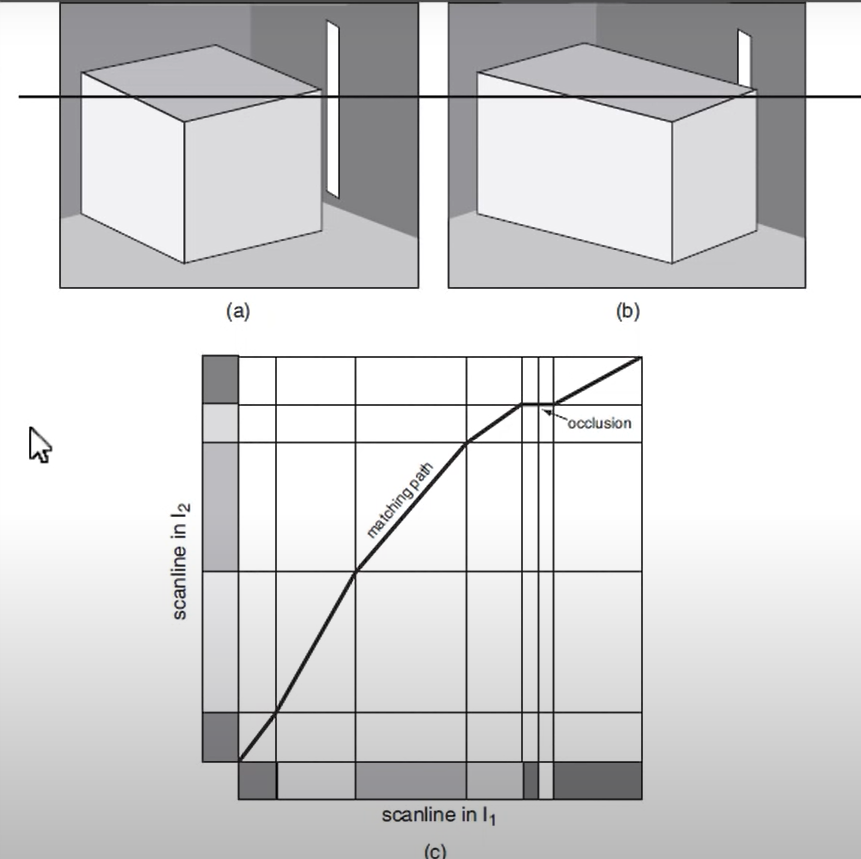

In [8]:
def dynamic_prog_disparity(left_img, right_img, show=True, plot=True):
  rgray = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)
  lgray = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
  height, width = lgray.shape[:2]
  disparity_map_l = []
  disparity_map_r = []
  for scanline in tqdm(range(height)):
    m, b = calc_cost_scanline(rgray[scanline, :], lgray[scanline, :])
    disparity_map_l_row, disparity_map_r_row = construct_disparity_map(m, b, width)
    disparity_map_l.append(disparity_map_l_row)
    disparity_map_r.append(disparity_map_r_row)

  disparity_map_l = np.array(disparity_map_l)
  disparity_map_r = np.array(disparity_map_r)

  factor_l = 255/max(np.unique(disparity_map_l))
  factor_r = 255/max(np.unique(disparity_map_r))

  disparity_map_l = disparity_map_l *factor_l
  disparity_map_r = disparity_map_r *factor_r

  if show:
    #plot_imgs(disparity_map_l, disparity_map_r)
    cv2_imshow(disparity_map_l)
    cv2_imshow(disparity_map_r)
  if plot:
    show_plot(b, width)
  return disparity_map_l, disparity_map_r, b

def calc_cost_scanline(rgray_row, lgray_row, c0=1):
  width = np.shape(lgray_row)[0]
  m = np.empty([width, width])
  b = np.empty([width, width], dtype=int)

  # base cases
  m[0, 0] = dij(lgray_row[0], rgray_row[0])
  for rowDummy in range(width):
    #m[rowDummy, 0] = dij(lgray_row[rowDummy], rgray_row[0])
    m[rowDummy, 0] = rowDummy + 1 
  for colDummy in range(width):
    #m[0, colDummy] = dij(lgray_row[0], rgray_row[colDummy])
    m[0, colDummy] = colDummy + 1

  for i in range(1, width):
    for j in range(1, width):
      #print(f"({i},{j})")
      costs = np.array([m[i-1, j-1] + dij(lgray_row[i], rgray_row[j]), m[i-1, j] + c0, m[i, j-1] + c0])
      # argmin is VERY slow so we won't be using it
      #b[i, j] = int(np.unravel_index(np.argmin(costs), costs.shape)[0]) 
      m[i, j] = min(costs)
      for cost_idx in range(len(costs)):
        if m[i, j] == costs[cost_idx]:
          b[i, j] = cost_idx
  return m, b


def dij(Il_val, Ir_val, sigma=2): # square error measure
  return (int(Il_val) - int(Ir_val))**2 / (sigma**2)

def construct_disparity_map(m, b, width):
  disparity_row_l = np.zeros((width))
  disparity_row_r = np.zeros((width))
  i = width - 1
  j = width - 1
  while (i != 0 and j != 0):
    if b[i, j] == 0:
      
      disparity_row_l[i] = np.abs(i-j)
      disparity_row_r[j] = np.abs(i-j)
      i -= 1
      j -= 1
      
    elif b[i, j] == 1:
      
      disparity_row_l[i] = 0
      i -= 1
      
    elif b[i, j] == 2:
      
      disparity_row_r[j] = 0
      j -= 1
      
  return disparity_row_l, disparity_row_r

def show_plot(b, width):
  graph = []
  i = width - 1
  j = width - 1
  while (i != 0 and j != 0):
    if b[i, j] == 0:
      graph.append([i-1, j-1])
      i -= 1
      j -= 1
    elif b[i, j] == 1:
      graph.append([i-1, j])
      i -= 1
    elif b[i, j] == 2:
      graph.append([i, j-1])
      j -= 1
  
  x_coords = [x[0] for x in graph]
  y_coords = [y[1] for y in graph]
  plt.plot(x_coords, y_coords, "k.", lw=0)


100%|██████████| 289/289 [04:32<00:00,  1.06it/s]


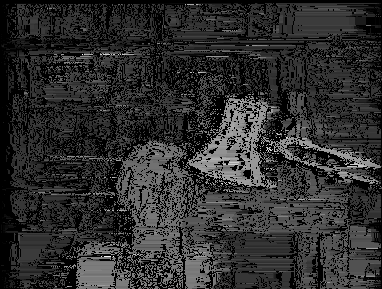

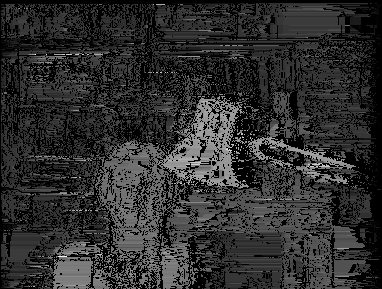

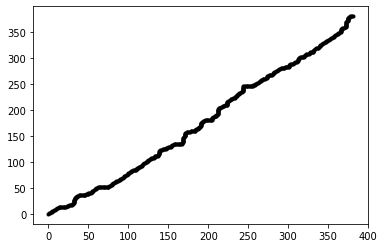

In [9]:
disparity_map_l, disparity_map_r, b = dynamic_prog_disparity(left_img1, right_img1, show=True, plot=True)